# Data-X Project: Electricity Price Prediction
## Feature Modeling Group: Machine Learning Optimization Pipeline


Retail electricity prices across different regions will have varying dependencies on all kinds of other signals in the energy marketplace. This notebook is an "pipeline" that integrates any available regional data (as well as national data) into an automated feature and machine learning model selection routine. The process is highly iterative and computationally intensive. However, the prediction of long term retail electricity prices is not time sensitive. It is not particularly desirable, but not necessarily awful for this notebook to run over the course of hours or days. 

The eventual output is visualizations of different models' average performances across ranges of feature combinations and hyperparameter combinations. The best-performing-on-average combination or combinations of [model X feature grouping X hyperparameter set] will be used (on their own or averaged) to make future predicitions of energy price. Other high performing combinations will combine to form tolerance bands for the prediction.

Team Members: Aaron Drew, Arbaaz Shakir, John Stuart, Adam Yankelevits, Eric Yehl

**Note:** This notebook needs to be launched by typing: 
jupyter lab Project.ipynb --NotebookApp.iopub_data_rate_limit=10000000000

## Import Libraries

Import open source packages and files defining custom functions.

In [409]:
%run helper_functions.py 

## Data Collection

Source data streams for a particular region (probably manual).

## Data Aggregation

Stitch many data streams into a Google Sheet and create a pandas dataframe by importing from Sheets API.

Columns: Features

Rows: Timestamps

In [614]:
%run helper_functions.py 
raw_data_full = import_sheet('TOY DATA 2')

In [ ]:
raw_data = raw_data_full.iloc[:].reset_index(drop=True)
raw_data.head()

In [ ]:
# plt.close("all")
# %run helper_functions.py 
# signal_plot(raw_data)

## Data Cleaning

Fill in missing values using interpolation, or condense high resolution data.

## Data Transformation

Standardize signals. Split data into a past to train on and a future to compare to.

[No longer a goal] Convert data signals to smooth moving averages, removing seasonal oscillations.

[No longer a goal] Track average, seasonal peaks, and seasonal troughs.

[No longer a goal] Find best fit polynomial for seasonal deviation over the course of one year.

In [615]:
%run helper_functions.py

pred_len = 60
raw_all_data = flip_df(raw_data)
raw_test_data = raw_all_data.iloc[pred_len:len(raw_all_data)]
raw_all_data.head()

,AllFuelsGen,AvgMaxTemp,AvgRelHum,AvgRetailPrice,AvgTemp,BiofuelsCons,BiomassCons,CoalGen,CommElecNetGen,CommNatGasCons,...,TotCoalCons,TotElecNetGen,TotIndNatGasCons,TotIndOtherNatGasCons,TotNatGasCons,TotRetailElecSales,TotTransNatGasCons,WasteCons,WindCons,WoodCons
0,20980.32,94.58,51.96,11.02,77.49,197.74,408.80,23.13,1.10,134.48,...,48.02,400.02,760.38,623.95,2111.26,24342.40,57.27,40.35,146.41,170.71
1,18260.49,88.70,55.66,10.87,72.78,198.38,401.25,26.83,1.05,139.02,...,55.52,355.77,741.75,611.05,1890.42,22235.31,51.53,39.32,181.06,163.55
2,16878.56,78.68,60.21,10.37,63.81,199.78,403.03,14.41,1.01,179.21,...,39.54,321.20,758.14,624.51,1886.70,19838.08,51.55,41.20,208.06,162.05
3,15436.07,76.20,48.93,10.10,62.91,182.92,382.85,19.34,0.90,213.26,...,43.50,293.68,754.27,625.27,1914.40,17875.54,52.14,41.61,236.73,158.32
4,16101.85,71.74,48.52,10.34,61.41,190.12,404.14,27.06,1.05,373.14,...,55.85,317.93,824.20,691.12,2513.84,19947.98,67.47,45.03,238.56,168.99


In [616]:
%run helper_functions.py

std_all_data, all_rescaler = standardize(raw_all_data, feature_range=[2,4], comp_var='Price')
std_test_data, test_rescaler1 = standardize(raw_test_data, feature_range=[2,4], comp_var='Price')
std_all_data.head()

,AllFuelsGen,AvgMaxTemp,AvgRelHum,AvgRetailPrice,AvgTemp,BiofuelsCons,BiomassCons,CoalGen,CommElecNetGen,CommNatGasCons,...,TotCoalCons,TotElecNetGen,TotIndNatGasCons,TotIndOtherNatGasCons,TotNatGasCons,TotRetailElecSales,TotTransNatGasCons,WasteCons,WindCons,WoodCons
0,3.403972,3.829829,2.966017,3.995327,3.707631,3.932231,3.888799,2.077525,3.621622,2.063336,...,2.173665,3.696911,3.312759,3.202027,2.809354,3.398367,2.673360,3.344933,3.214207,2.949232
1,2.963882,3.542298,3.093669,3.925234,3.418940,3.939061,3.820707,2.110420,3.486486,2.083444,...,2.286143,3.081130,3.190298,3.107959,2.568756,2.999104,2.481258,3.239509,3.509679,2.643771
2,2.740275,3.052323,3.250647,3.691589,2.869139,3.954002,3.836760,2.000000,3.378378,2.261449,...,2.046491,2.600056,3.298035,3.206111,2.564703,2.544863,2.481928,3.431934,3.739916,2.579778
3,2.506868,2.931051,2.861480,3.565421,2.813975,3.774066,3.654762,2.043830,3.081081,2.412260,...,2.105879,2.217089,3.272596,3.211653,2.594882,2.172989,2.501673,3.473900,3.984395,2.420648
4,2.614597,2.712958,2.847335,3.677570,2.722035,3.850907,3.846771,2.112464,3.486486,3.120383,...,2.291092,2.554551,3.732268,3.691837,3.247952,2.565687,3.014726,3.823951,4.000000,2.875853


## Exploratory Data Analysis with Correlation Matrices

### Pearson correlation matrix "heat map" for colinearity between all features.

In [ ]:
# plt.close("all")
# %run helper_functions.py
# reg_heat_map(std_test_data)

### Time displaced correlations of all features with price

Displace (advance) feature signals by n months. This will line up past signals with future prices. Truncate n months at the end of feature signals and n months at the beginning of price signals.

In [ ]:
# plt.close("all")
# %run helper_functions.py 
# time_heat_map(std_test_data, months=60)

## Feature Construction

Create new features using derivatives (perhaps first interpolating with polynomials, then taking the derivative(s) of these instead of using finite difference), powers, time offsets, and perhaps products and quotients of these. Do this intelligently so as not to create an intractable amount of combinations.

In [ ]:
new_test_data6

In [617]:
%run helper_functions.py 
new_test_data0 = keep_distinct_features(std_test_data, corr_cut=1, look_back=7)

Checking 33 with 26 of 58 total 

5 features thrown out due to correlation with other features. 0 NaNs resulted from Pearson calculations


In [618]:
%run helper_functions.py 
new_test_data1 = new_features_with_funcs(new_test_data0,\
                                   [cumtrapz_ext, diff_ext, np.log, np.sqrt, np.square, np.exp],\
                                   ['Int', 'Diff', 'Log', 'Sqrt', 'Square', 'Exp'],\
                                   filter=True,\
                                   corr_cut=0.8,\
                                   look_back=7)

9 net new features created with functions. 333 new features were thrown out due to poor correlation with price at all month offsets from 0 to 7


In [619]:
%run helper_functions.py 
new_test_data2 = new_features_with_combs(new_test_data1, combiners=['*','/'], filter=True, corr_cut=0.8, look_back=7)

529 net new features created with combinations. 5906 new features were thrown out due to poor correlation with Price


In [620]:
%run helper_functions.py 
new_test_data3 = keep_distinct_features(new_test_data2, corr_cut=.9, look_back=7)

Checking 1 with 204 of 595 total 

Checking 1 with 483 of 595 total 

Checking 2 with 172 of 592 total 

Checking 2 with 434 of 592 total 

Checking 4 with 564 of 580 total 

545 features thrown out due to correlation with other features. 0 NaNs resulted from Pearson calculations                                                                                                                                                                                                                                          


In [641]:
%run helper_functions.py 
new_test_data4 = trim_features(new_test_data3, corr_cut=.9, look_back=48)

46 features thrown out due to poor correlation with price at all month offsets from 0 to 48


In [ ]:
# %run helper_functions.py 
# new_test_data5 = new_features_with_funcs(new_test_data4,\
#                                    [cumtrapz_ext, diff_ext, np.log, np.sqrt, np.square, np.exp],\
#                                    ['Int', 'Diff', 'Log', 'Sqrt', 'Square', 'Exp'],\
#                                    filter=True,\
#                                    corr_cut=0.8,\
#                                    look_back=7)

In [ ]:
# %run helper_functions.py 
# new_test_data6 = new_features_with_combs(new_test_data5, combiners=['*','/'], filter=True, corr_cut=0.7, look_back=7)

In [ ]:
# %run helper_functions.py 
# new_test_data7 = keep_distinct_features(new_test_data6, corr_cut=.9, look_back=7)

In [ ]:
# %run helper_functions.py 
# new_test_data8 = trim_features(new_test_data7, corr_cut=.75, look_back=48)

In [642]:
new_test_data = new_test_data4

In [643]:
list(new_test_data)

['Price',
 'IndLPNatGasCons*PriceSquare',
 'PriceSquare/ElecExports',
 'TotRetailElecSales*PriceSquare']

In [644]:
len(list(new_test_data))

4

## New Correlation Matrices

Pearson correlation matrix "heat map" for colinearity between all features (old and new).

Time displaced correlation matrix "heat map" for colinearity between all features (old and new) and electricity price at offset times.

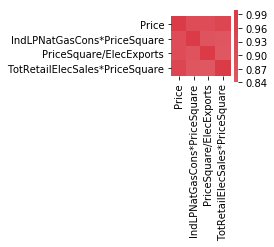

In [662]:
plt.close("all")
%run helper_functions.py 
reg_heatmap = reg_heat_map(new_test_data)
reg_heatmap

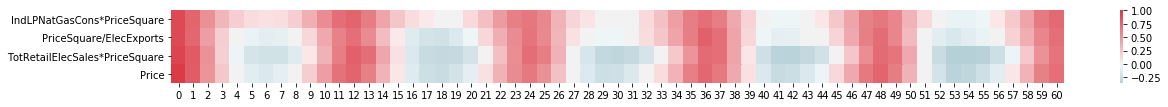

In [663]:
plt.close("all")
%run helper_functions.py 
time_heatmap = time_heat_map(new_test_data,months=60)
time_heatmap

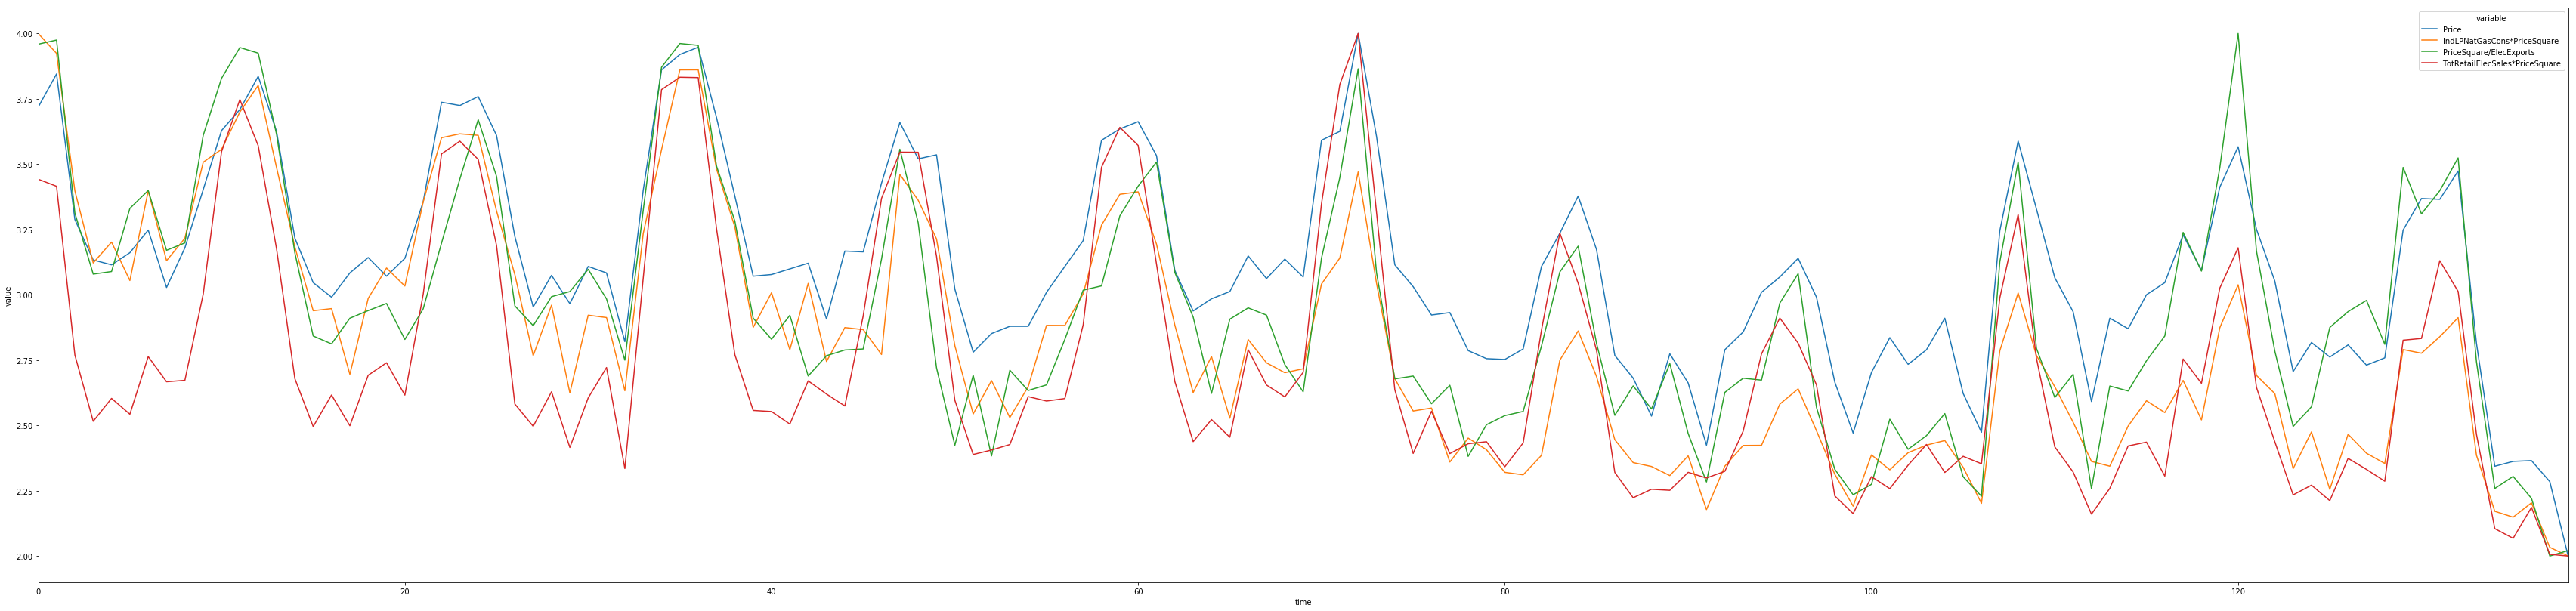

In [675]:
plt.close("all")
%run helper_functions.py 
signal_plot(new_test_data)

## Create Test Matrix of Model/Feature Combinations

Pandas dataframe with:

Columns: Features, Hyperparameters, 1 column for model type, 1 column for average test results
Rows: Different combinations of the above
Data: 1's and 0's for feature inclusion, hyperparameter values, average test results

## Run Test Matrix of Model/Feature Combinations

Run many separate model trainings & performance tests for each combination below, averaging the __test__ results:

[ML algorithm X hyperparameter set X feature grouping]

Fill out pandas dataframe with average performance test results.


## Visualize Performance Matrix

Display test results graphically.

## Make Predictions

## New Thoughts

Maybe predicting a signal is not one model... it can be a collection of models that are each responsible for predicting a single future timestep. Each part of the future will have different dependencies on the past. Each time delta (e.g. +5 months in the future) should then be trained as a separate model. These models' predictions would be combined and smoothed to form a cohesive prediction signal. 

We can first construct an enormous set of features using transformations: square, log, exponent, derivative, integral. Then combinations of these: product, quotient, exponent. Then maybe even transformations of the combinations! We can easily turn 20 features that we think might have some unique substance into several million, producing and exploring nonlinear relationships by force.

We can filter features as they are constructed based on some basic correlation criteria (too correlated with others, uncorrelated with price).

This would be to perform manageable LassoCV (= Lasso + regularization) regressions for each future timestep. Lasso automatically selects the best few features, even from many thousands. We would normalize all features before running Lasso, but after doing feature construction.

This strategy is forcing a complex future prediction problem into a linear regression mold. It allows classic test-train splitting, which means we can have an accurate understanding of our ultimate predictive power. 

The time delay aspect of feature construction will be the most interesting I believe. Training for a model whose job is to predict the 5 month future price will match the y_train signal with x_train signals from 5 months in the past and before. And before? ... For a 5 month future prediction, I hypothesize that we won't just want to look at a 5 month old slice of signals. Rather, we want to look at the whole body of data from 5 months ago and further back into the past. All of a particular future price's 6 month old, 7 month old, 1 year old data become features of that price. This is some seriously epic dataframe manipulation.

ARMA, ARIMA, SARIMA are time series forecasting models that also look into the past, but quite differently (these models are actually univariate... the multivariate one is call VAR (vector auto-regression) which works for our case, where we think other signals are influencing the signal we are interested in.

In [ ]:
# %run helper_functions.py 
# slid = slide_df(new_data, 40, 24, purpose = 'train')
# slid.head()

In [ ]:
# reg_heat_map(slid)

In [664]:
new_test_data.head()

,Price,IndLPNatGasCons*PriceSquare,PriceSquare/ElecExports,TotRetailElecSales*PriceSquare
0,3.718266,55.302016,6.021485,44.342425
1,3.845201,53.607409,6.058585,43.726877
2,3.287926,41.884911,4.509783,29.074321
3,3.133127,35.732329,3.963799,23.325311
4,3.114551,37.509039,3.986675,25.310750


In [661]:
%run helper_functions.py 
sample_train_slid_df = slide_df(new_test_data, 60, 60, purpose='train')
sample_train_slid_df

,Price,Price-60,IndLPNatGasCons*PriceSquare-60,PriceSquare/ElecExports-60,TotRetailElecSales*PriceSquare-60,Price-61,IndLPNatGasCons*PriceSquare-61,PriceSquare/ElecExports-61,TotRetailElecSales*PriceSquare-61,Price-62,...,PriceSquare/ElecExports-117,TotRetailElecSales*PriceSquare-117,Price-118,IndLPNatGasCons*PriceSquare-118,PriceSquare/ElecExports-118,TotRetailElecSales*PriceSquare-118,Price-119,IndLPNatGasCons*PriceSquare-119,PriceSquare/ElecExports-119,TotRetailElecSales*PriceSquare-119
0,3.718266,3.662539,41.796494,4.751574,47.271862,3.532508,37.335783,4.966344,36.965483,3.092879,...,4.336797,28.727380,3.092879,22.342477,3.990595,26.622222,3.411765,30.199353,4.915119,34.885963
1,3.845201,3.532508,37.335783,4.966344,36.965483,3.092879,30.424699,3.978611,26.773755,2.938080,...,3.990595,26.622222,3.411765,30.199353,4.915119,34.885963,3.566563,33.867075,6.117264,38.389624
2,3.287926,3.092879,30.424699,3.978611,26.773755,2.938080,24.677401,3.579569,21.555128,2.984520,...,4.915119,34.885963,3.566563,33.867075,6.117264,38.389624,3.250774,26.136892,4.169809,26.267027
3,3.133127,2.938080,24.677401,3.579569,21.555128,2.984520,27.749001,2.895938,23.472052,3.012384,...,6.117264,38.389624,3.250774,26.136892,4.169809,26.267027,3.052632,24.588425,3.275687,21.554378
4,3.114551,2.984520,27.749001,2.895938,23.472052,3.012384,22.489198,3.560375,21.940300,3.148607,...,4.169809,26.267027,3.052632,24.588425,3.275687,21.554378,2.705882,18.186078,2.600177,16.935143
5,3.160991,3.012384,22.489198,3.560375,21.940300,3.148607,29.195742,3.661469,29.534614,3.061920,...,3.275687,21.554378,2.705882,18.186078,2.600177,16.935143,2.817337,21.317061,2.776082,17.776663
6,3.247678,3.148607,29.195742,3.661469,29.534614,3.061920,27.211069,3.596914,26.474161,3.136223,...,2.600177,16.935143,2.817337,21.317061,2.776082,17.776663,2.761610,16.421094,3.486036,16.436091
7,3.027864,3.061920,27.211069,3.596914,26.474161,3.136223,26.366832,3.153406,25.442723,3.068111,...,2.776082,17.776663,2.761610,16.421094,3.486036,16.436091,2.808050,21.115700,3.628213,20.105018
8,3.179567,3.136223,26.366832,3.153406,25.442723,3.068111,26.701836,2.910141,27.573663,3.591331,...,3.486036,16.436091,2.808050,21.115700,3.628213,20.105018,2.730650,19.501802,3.728225,19.146870
9,3.402477,3.068111,26.701836,2.910141,27.573663,3.591331,33.932578,4.106496,42.215359,3.625387,...,3.628213,20.105018,2.730650,19.501802,3.728225,19.146870,2.758514,18.626934,3.335132,18.119256


In [ ]:
# %run helper_functions.py 
# sample_test_slid_df = slide_df(new_test_data, 0, 4, purpose='train')
# sample_test_slid_df.head()

[(1, 60, 0.82999999999999996, -0.0015), (2, 48, 0.87, -0.0015), (3, 72, 0.80000000000000004, -0.00115), (4, 72, 0.80000000000000004, -0.00115), (5, 60, 0.80000000000000004, -0.0015), (6, 72, 0.80000000000000004, -0.0015), (7, 60, 0.82999999999999996, -0.00080000000000000004), (8, 60, 0.80000000000000004, -0.0015), (9, 48, 0.82999999999999996, -0.00115), (10, 48, 0.80000000000000004, -0.00115), (11, 60, 0.80000000000000004, -0.00115), (12, 48, 0.80000000000000004, -0.0015), (13, 60, 0.80000000000000004, -0.00115), (14, 36, 0.80000000000000004, -0.0015), (15, 48, 0.82999999999999996, -0.0015), (16, 48, 0.80000000000000004, -0.0015), (17, 48, 0.80000000000000004, -0.00115), (18, 48, 0.82999999999999996, -0.00044999999999999999), (19, 48, 0.82999999999999996, -0.00080000000000000004), (20, 48, 0.82999999999999996, -0.0015), (21, 48, 0.80000000000000004, -0.0015), (22, 36, 0.82999999999999996, -0.0015), (23, 48, 0.80000000000000004, -0.00115), (24, 48, 0.80000000000000004, -0.00044999999999

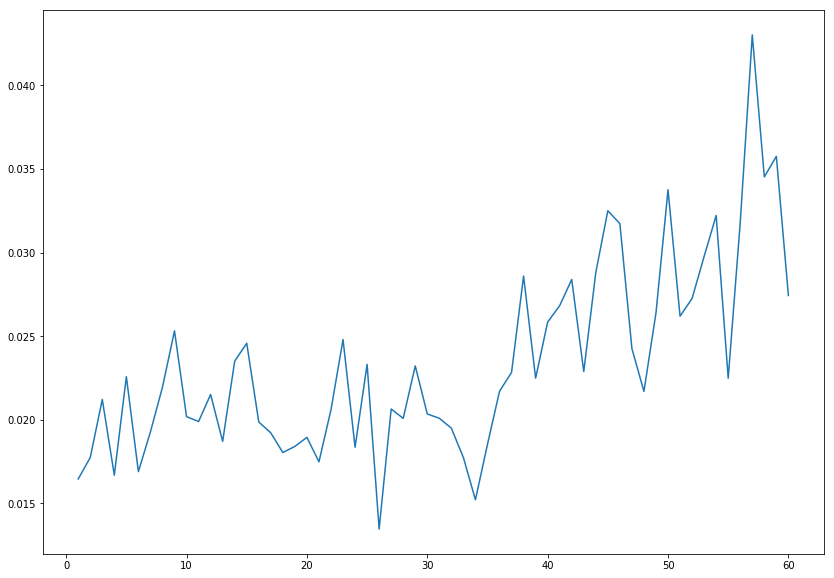

In [665]:
%run helper_functions.py 
plt.close("all")

# (best_hps, training_dfs) = \
#     train_hopping_lasso(new_test_data4, comp_var='Price', 
#                         pred_len=pred_len, iter=25, 
#                         look_back_step=6, #look_back_override='single', 
#                         test_props=list(np.arange(.1,.2,.025)), 
# #                         test_props = [.15], 
#                         n_alphas=20, cv=5, eps=.0001)

best_hps, training_dfs, sample_dfs = \
    train_hopping_lasso(new_test_data, comp_var='Price', 
                        pred_len=60, iter=1, 
                        look_back_step=12, #look_back_override='single', 
                        test_props=list(np.linspace(.1,.2,4)), 
#                         test_props = [.15,2], 
                        model_type=Lasso,
                        n_alphas=5)


In [666]:
# print([df['alpha'].values[0] for df in training_dfs])
# plt.plot([df['alpha'].values[0] for df in training_dfs])
# plt.show()

In [667]:
training_dfs[0]

len_data  n_iter  num_feats  \
offset look_back train_prop neg_alpha                                
1      12        0.80       -0.00150        127      47          5   
                            -0.00115        127      47          6   
                            -0.00080        127      55          6   
                            -0.00045        127     106         13   
                            -0.00010        127     297         18   
                 0.83       -0.00150        127      49          5   
                            -0.00115        127      55          6   
                            -0.00080        127      69          8   
                            -0.00045        127      88         10   
                            -0.00010        127     363         22   
                 0.87       -0.00150        127      47          5   
                            -0.00115        127      68          7   
                            -0.00080        127      64          8   
                            -0.00045        127      89         10   
                            -0.00010        127     294         19   
                 0.90       -0.00150        127      49          5   
                            -0.00115        127      47          6   
                            -0.00080        127      64          6   
                            -0.00045        127     110         10   
                            -0.00010        127     349         21   
       24        0.80       -0.00150        115      97          8   
                            -0.00115        115      89         10   
                            -0.00080        115     117         10   
                            -0.00045        115     140         21   
                            -0.00010        115     852         31   
                 0.83       -0.00150        115      92          9   
                            -0.00115        115      95          9   
                            -0.00080        115     114         11   
                            -0.00045        115     108         20   
                            -0.00010        115     478         27   
...                                         ...     ...        ...   
       48        0.80       -0.00150         91     100          9   
                            -0.00115         91     115         12   
                            -0.00080         91     152         19   
                            -0.00045         91     204         17   
                            -0.00010         91    1000         28   
                 0.83       -0.00150         91     147         11   
                            -0.00115         91     102         12   
                            -0.00080         91     134         14   
                            -0.00045         91     236         18   
                            -0.00010         91    1000         32   
                 0.87       -0.00150         91      93         11   
                            -0.00115         91      83         12   
                            -0.00080         91     202         13   
                            -0.00045         91     297         19   
                            -0.00010         91    1000         34   
       60        0.80       -0.00150         79     116         10   
                            -0.00115         79     177          9   
                            -0.00080         79     170         14   
                            -0.00045         79     379         16   
                            -0.00010         79    1000         37   
                 0.83       -0.00150         79     139         10   
                            -0.00115         79     200         12   
                            -0.00080         79     168         14   
                            -0.00045         79     303         20   
                            -0.00010         79  

In [668]:
for sample_df in sample_dfs:
    for index in sample_df.index:
        print(str(index)+': '+sample_df.loc[index].kept_feats)

(1, 12, 0.8, -0.0015): Price-1+IndLPNatGasCons*PriceSquare-1+TotRetailElecSales*PriceSquare-10+TotRetailElecSales*PriceSquare-11+TotRetailElecSales*PriceSquare-12
(1, 12, 0.8, -0.00115): Price-1+IndLPNatGasCons*PriceSquare-1+PriceSquare/ElecExports-6+TotRetailElecSales*PriceSquare-10+TotRetailElecSales*PriceSquare-11+TotRetailElecSales*PriceSquare-12
(1, 12, 0.8, -0.0008): Price-1+IndLPNatGasCons*PriceSquare-1+PriceSquare/ElecExports-3+TotRetailElecSales*PriceSquare-10+TotRetailElecSales*PriceSquare-11+TotRetailElecSales*PriceSquare-12
(1, 12, 0.8, -0.00045): Price-1+IndLPNatGasCons*PriceSquare-1+TotRetailElecSales*PriceSquare-1+PriceSquare/ElecExports-3+TotRetailElecSales*PriceSquare-6+Price-8+PriceSquare/ElecExports-9+TotRetailElecSales*PriceSquare-9+TotRetailElecSales*PriceSquare-10+IndLPNatGasCons*PriceSquare-11+TotRetailElecSales*PriceSquare-11+PriceSquare/ElecExports-12+TotRetailElecSales*PriceSquare-12
(1, 12, 0.8, -0.0001): Price-1+IndLPNatGasCons*PriceSquare-1+TotRetailElecSal

(2, 24, 0.83, -0.0001): Price-2+IndLPNatGasCons*PriceSquare-2+IndLPNatGasCons*PriceSquare-3+PriceSquare/ElecExports-4+IndLPNatGasCons*PriceSquare-6+TotRetailElecSales*PriceSquare-6+IndLPNatGasCons*PriceSquare-7+Price-8+IndLPNatGasCons*PriceSquare-8+PriceSquare/ElecExports-9+TotRetailElecSales*PriceSquare-10+IndLPNatGasCons*PriceSquare-11+TotRetailElecSales*PriceSquare-11+PriceSquare/ElecExports-12+TotRetailElecSales*PriceSquare-12+IndLPNatGasCons*PriceSquare-13+TotRetailElecSales*PriceSquare-13+IndLPNatGasCons*PriceSquare-14+IndLPNatGasCons*PriceSquare-15+TotRetailElecSales*PriceSquare-15+PriceSquare/ElecExports-16+IndLPNatGasCons*PriceSquare-17+PriceSquare/ElecExports-17+IndLPNatGasCons*PriceSquare-18+TotRetailElecSales*PriceSquare-18+IndLPNatGasCons*PriceSquare-21+IndLPNatGasCons*PriceSquare-22+TotRetailElecSales*PriceSquare-22+PriceSquare/ElecExports-23+TotRetailElecSales*PriceSquare-23+PriceSquare/ElecExports-24+TotRetailElecSales*PriceSquare-24
(2, 24, 0.87, -0.0015): IndLPNatGasC

(6, 36, 0.87, -0.0001): IndLPNatGasCons*PriceSquare-6+PriceSquare/ElecExports-7+Price-8+TotRetailElecSales*PriceSquare-10+TotRetailElecSales*PriceSquare-11+IndLPNatGasCons*PriceSquare-14+IndLPNatGasCons*PriceSquare-15+IndLPNatGasCons*PriceSquare-17+IndLPNatGasCons*PriceSquare-18+PriceSquare/ElecExports-19+Price-21+IndLPNatGasCons*PriceSquare-22+TotRetailElecSales*PriceSquare-22+TotRetailElecSales*PriceSquare-23+Price-24+TotRetailElecSales*PriceSquare-24+PriceSquare/ElecExports-27+PriceSquare/ElecExports-28+IndLPNatGasCons*PriceSquare-30+TotRetailElecSales*PriceSquare-30+TotRetailElecSales*PriceSquare-33+IndLPNatGasCons*PriceSquare-34+TotRetailElecSales*PriceSquare-35+Price-36+TotRetailElecSales*PriceSquare-36+Price-37+IndLPNatGasCons*PriceSquare-37+IndLPNatGasCons*PriceSquare-38+Price-40+Price-41
(6, 48, 0.8, -0.0015): Price-11+TotRetailElecSales*PriceSquare-11+Price-12+TotRetailElecSales*PriceSquare-12+PriceSquare/ElecExports-13+IndLPNatGasCons*PriceSquare-14+PriceSquare/ElecExports-2

(23, 12, 0.87, -0.0015): TotRetailElecSales*PriceSquare-23+TotRetailElecSales*PriceSquare-24+TotRetailElecSales*PriceSquare-25+IndLPNatGasCons*PriceSquare-30+IndLPNatGasCons*PriceSquare-34+TotRetailElecSales*PriceSquare-34
(23, 12, 0.87, -0.00115): TotRetailElecSales*PriceSquare-23+TotRetailElecSales*PriceSquare-24+TotRetailElecSales*PriceSquare-25+IndLPNatGasCons*PriceSquare-30+IndLPNatGasCons*PriceSquare-34+TotRetailElecSales*PriceSquare-34
(23, 12, 0.87, -0.0008): TotRetailElecSales*PriceSquare-23+TotRetailElecSales*PriceSquare-24+TotRetailElecSales*PriceSquare-25+IndLPNatGasCons*PriceSquare-30+IndLPNatGasCons*PriceSquare-34+TotRetailElecSales*PriceSquare-34
(23, 12, 0.87, -0.00045): TotRetailElecSales*PriceSquare-23+TotRetailElecSales*PriceSquare-24+TotRetailElecSales*PriceSquare-25+PriceSquare/ElecExports-26+TotRetailElecSales*PriceSquare-26+IndLPNatGasCons*PriceSquare-27+IndLPNatGasCons*PriceSquare-29+IndLPNatGasCons*PriceSquare-30+TotRetailElecSales*PriceSquare-33+IndLPNatGasCon

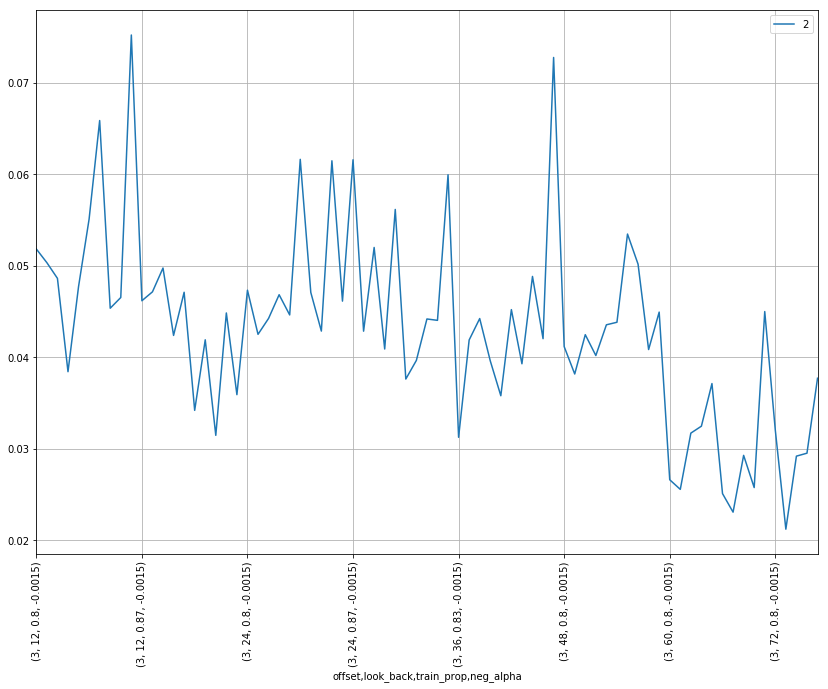

In [669]:
for i in range(len(training_dfs)):
    if i==2:
        training_dfs[i].test_error.plot(label=str(i))
plt.xticks(rotation=90)
plt.legend()
plt.grid()
plt.show()

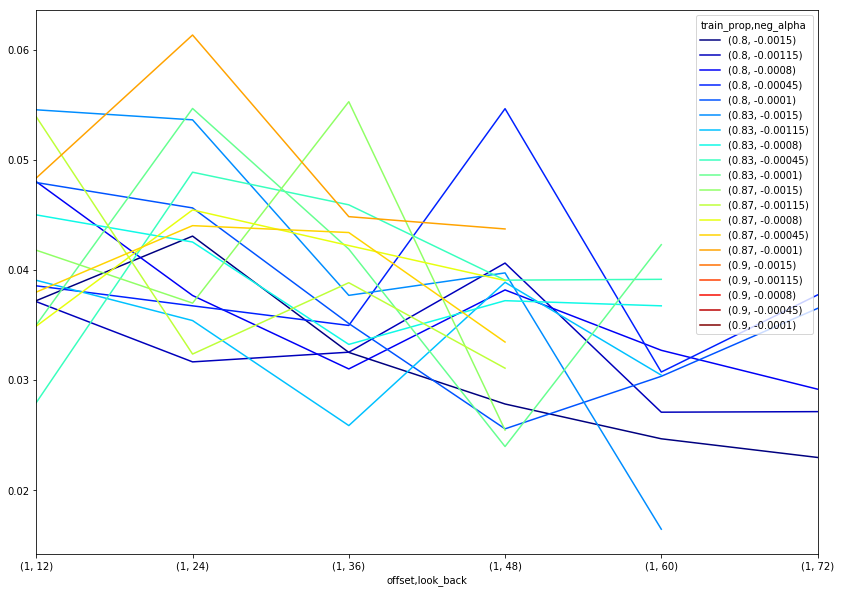

In [670]:
plt.close("all")
training_dfs[0].unstack(level=-2, fill_value=None).unstack(level=-1, fill_value=None).test_error.plot(colormap='jet')
plt.show()

In [671]:
%run helper_functions.py 
plt.close("all")

predictions = hopping_lasso_predict(new_test_data, best_hps, iter=10, comp_var='Price')
predictions

,avg_prediction,std,+std,-std
offset,,,,
1,3.8897,0.019630,3.909330,3.870070
2,3.6760,0.036621,3.712621,3.639379
3,3.4485,0.048578,3.497078,3.399922
4,3.1049,0.056846,3.161746,3.048054
5,2.9878,0.043805,3.031605,2.943995
6,2.9839,0.084011,3.067911,2.899889
7,2.9471,0.024551,2.971651,2.922549
8,3.0669,0.027546,3.094446,3.039354
9,3.0754,0.021961,3.097361,3.053439


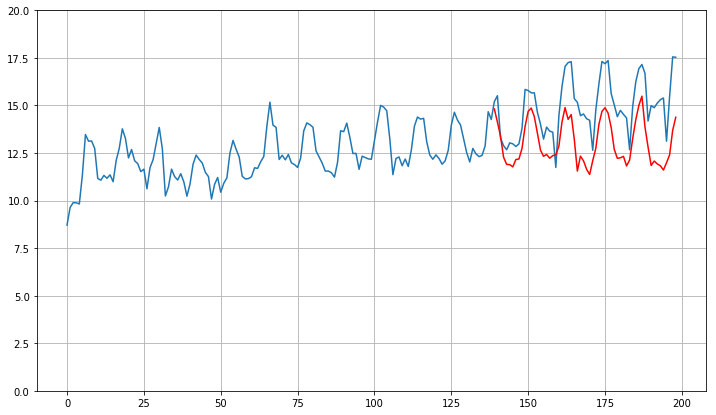

In [672]:
%run helper_functions.py 
plt.close("all")
pred_len=60
scaled_predictions_df = test_rescaler1(predictions)
preds = scaled_predictions_df.avg_prediction
preds_max = scaled_predictions_df['+std']
preds_min = scaled_predictions_df['-std']
plt.figure(figsize=(12,7))
plt.plot(range(len(std_all_data)), all_rescaler(flip_df(std_all_data).Price))
plt.plot(range(len(std_all_data)-pred_len, len(std_all_data)),[pred for pred in preds], 'r')
# plt.plot(range(len(std_all_data)-pred_len, len(std_all_data)),[pred for pred in preds_max], '--r', linewidth=1)
# plt.plot(range(len(std_all_data)-pred_len, len(std_all_data)),[pred for pred in preds_min], '--r', linewidth=1)
plt.ylim([0,20])
# plt.xlim([len(std_all_data)-len(preds), len(std_all_data)])
plt.grid()
plt.show()

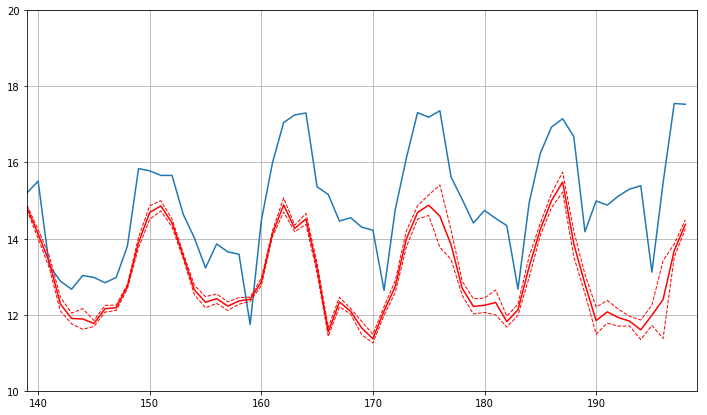

In [673]:
plt.figure(figsize=(12,7))
plt.plot(range(len(std_all_data)), all_rescaler(flip_df(std_all_data).Price))
# plt.plot(range(len(std_all_data)-pred_len, len(std_all_data)),[pred for pred in preds], '+r')
plt.plot(range(len(std_all_data)-pred_len, len(std_all_data)),[pred for pred in preds], 'r')
plt.plot(range(len(std_all_data)-pred_len, len(std_all_data)),[pred for pred in preds_max], '--r', linewidth=1)
plt.plot(range(len(std_all_data)-pred_len, len(std_all_data)),[pred for pred in preds_min], '--r', linewidth=1)
plt.ylim([10,20])
plt.xlim([len(std_all_data)-len(preds), len(std_all_data)])
plt.grid()
plt.show()

In [674]:
np.linspace(.1,.25,5)

array([ 0.1   ,  0.1375,  0.175 ,  0.2125,  0.25  ])

In [681]:
training_dfs[0].head()

len_data  n_iter  num_feats  \
offset look_back train_prop neg_alpha                                
1      12        0.8        -0.00150        127      47          5   
                            -0.00115        127      47          6   
                            -0.00080        127      55          6   
                            -0.00045        127     106         13   
                            -0.00010        127     297         18   

                                       test_error  test_num  train_error  \
offset look_back train_prop neg_alpha                                      
1      12        0.8        -0.00150     0.037212        26     0.036994   
                            -0.00115     0.037122        26     0.037308   
                            -0.00080     0.048016        26     0.032996   
                            -0.00045     0.038559        26     0.033392   
                            -0.00010     0.047942        26     0.027834   

                                       train_num  
offset look_back train_prop neg_alpha             
1      12        0.8        -0.00150         101  
                            -0.00115         101  
                            -0.00080         101  
                            -0.00045         101  
                            -0.00010         101

In [ ]:
new_test_data.to_json

In [680]:
print(training_dfs[0].to_json())

{"len_data":{"[1,12,0.8,-0.0015]":127,"[1,12,0.8,-0.00115]":127,"[1,12,0.8,-0.0008]":127,"[1,12,0.8,-0.00045]":127,"[1,12,0.8,-0.0001]":127,"[1,12,0.83,-0.0015]":127,"[1,12,0.83,-0.00115]":127,"[1,12,0.83,-0.0008]":127,"[1,12,0.83,-0.00045]":127,"[1,12,0.83,-0.0001]":127,"[1,12,0.87,-0.0015]":127,"[1,12,0.87,-0.00115]":127,"[1,12,0.87,-0.0008]":127,"[1,12,0.87,-0.00045]":127,"[1,12,0.87,-0.0001]":127,"[1,12,0.9,-0.0015]":127,"[1,12,0.9,-0.00115]":127,"[1,12,0.9,-0.0008]":127,"[1,12,0.9,-0.00045]":127,"[1,12,0.9,-0.0001]":127,"[1,24,0.8,-0.0015]":115,"[1,24,0.8,-0.00115]":115,"[1,24,0.8,-0.0008]":115,"[1,24,0.8,-0.00045]":115,"[1,24,0.8,-0.0001]":115,"[1,24,0.83,-0.0015]":115,"[1,24,0.83,-0.00115]":115,"[1,24,0.83,-0.0008]":115,"[1,24,0.83,-0.00045]":115,"[1,24,0.83,-0.0001]":115,"[1,24,0.87,-0.0015]":115,"[1,24,0.87,-0.00115]":115,"[1,24,0.87,-0.0008]":115,"[1,24,0.87,-0.00045]":115,"[1,24,0.87,-0.0001]":115,"[1,36,0.8,-0.0015]":103,"[1,36,0.8,-0.00115]":103,"[1,36,0.8,-0.0008]":103,"[